In [2]:
#Bibliotecas:
import numpy as np
import pandas as pd
from qutip import *
import csv 
import latex
import time

import matplotlib.pyplot as plt 
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": "18",
    "font.serif": ["Times New Roman"]})
import matplotlib
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13)
matplotlib.rc('legend', fontsize=13) 
import matplotlib.gridspec as gridspec
from palettable.colorbrewer.qualitative import Set1_5

In [33]:
def mean_number_photons(delta,input_list,times,psi0):

    """
    This function handles the time evolution and returns the mean number 
    of photons for each value of detuning.
    """
    
    Nat = input_list[0]
    N = input_list[1] 
    kappa = input_list[2]
    g = input_list[3]
    EM = input_list[4]
    Oc = input_list[5]
    norm = input_list[6]
    
    G31 = input_list[7]
    G32 = input_list[8]
    D1 = input_list[9]
    D2 = input_list[10]
    
    #field operator
    op_list = []
    for m in range(Nat+1):
        op_list.append(qeye(3))
    op_list[0] = destroy(N)
    a = tensor(op_list) #muda conforme o numero de atomos
    
    #atomic operators
    S11_list = []
    S22_list = []
    S33_list = []
    S13_list = []
    S23_list = []
    
    for n in range(Nat):
        op_list = []
        for m in range(Nat+1):
            op_list.append(qeye(3))

        op_list[0] = qeye(N)
        
        op_list[n+1] = basis(3,0)*basis(3,0).dag()
        S11_list.append(tensor(op_list))

        op_list[n+1] = basis(3,1)*basis(3,1).dag()
        S22_list.append(tensor(op_list))

        op_list[n+1] = basis(3,2)*basis(3,2).dag()
        S33_list.append(tensor(op_list))
        
        op_list[n+1] = basis(3,0)*basis(3,2).dag()
        S13_list.append(tensor(op_list))
        
        op_list[n+1] = basis(3,1)*basis(3,2).dag()
        S23_list.append(tensor(op_list))        
       
    #total atomic operators
    S11 = 0
    S22 = 0
    S33 = 0
    S13 = 0
    S23 = 0
    
    for n in range(Nat):
        S11 = S11 + S11_list[n]
        S22 = S22 + S22_list[n]
        S33 = S33 + S33_list[n]
        S13 = S13 + S13_list[n]
        S23 = S23 + S23_list[n]

    #colapse Operators
    C = np.sqrt(kappa)*a   #cavity  
    C31_list = []
    C32_list = []
    
    for n in range(Nat):
        C31_list.append(np.sqrt(G31)*S13_list[n])
        C32_list.append(np.sqrt(G32)*S23_list[n])
    
    Clist = [C] + C31_list + C32_list

    Ht = D1*S33 + (D1-D2)*S22 + delta*S11 - delta*a.dag()*a + (g*a*S13.dag() + Oc*S23.dag() + EM*a + g*a.dag()*S13 + Oc*S23 + EM*a.dag())
        
    # monte carlo solver
    opt = Options(ntraj=1)
    data = mcsolve(Ht, psi0, times, Clist, [a.dag() * a], progress_bar=False, options=opt)
    nm_a = data.expect[0]/norm

    return nm_a

In [41]:
if __name__ == '__main__':   
    
    ini = time.time() #starts counting time
    print(time.ctime()) #print initial time
    kappa = 1.0 #cavity mode dissipation rate
    Oc_list = [0.01*kappa , 0.1*kappa, 0.5*kappa, 1*kappa, 2*kappa] #Rabi frequency list 
    Nat = 5    
    N = 6 #Fock space dimension
    g = (0.1/np.sqrt(Nat))*kappa #atom-field coupling strenght
    EM = np.sqrt(0.1)*kappa #pump field strength
    norm = 4*(EM/(kappa))**2 #normalization
    #decay rates
    G31 = 0.5*kappa  #atom
    G32 = 0.5*kappa  #atom
    #detunings
    D1 = 0.0
    D2 = 0.0
    Dp = 0.01*kappa
        
    times = np.linspace(0.0, 2100, 1050) #evolution time list
    aux_list = []
    for m in range(Nat+1):
        aux_list.append(basis(3,1))
    aux_list[0] = basis(N,0)
    psi0 = tensor(aux_list)
    
    trans_ss_list = []

    for j in range(len(Oc_list)):

        Oc = Oc_list[j]
        input_list = [Nat,N,kappa,g,EM,Oc,norm,G31,G32,D1,D2]
        trans_ss_list.append(mean_number_photons(Dp, input_list, times, psi0))
          
        #progress tracking
        fin = time.time() 

    data = np.vstack((times,trans_ss_list))
    file_data_store('timeevolution_g01_ep01_Nat5.csv',  data.T, numtype="real", numformat="decimal", sep= ",")  

Tue Dec  5 21:55:58 2023


In [3]:
N1 = np.loadtxt('timeevolution_g5_ep01.csv', delimiter=',')
N2 = np.loadtxt('timeevolution_g1_ep01.csv', delimiter=',')
N3 = np.loadtxt('timeevolution_g01_ep01.csv', delimiter=',')
N4 = np.loadtxt('timeevolution_g10_ep01.csv', delimiter=',')
N5 = np.loadtxt('timeevolution_g10_ep01_Nat2.csv', delimiter=',')
N6 = np.loadtxt('timeevolution_g10_ep01_Nat3.csv', delimiter=',')
N7 = np.loadtxt('timeevolution_g10_ep01_Nat4.csv', delimiter=',')
N8 = np.loadtxt('timeevolution_g10_ep01_Nat5.csv', delimiter=',')
N9 = np.loadtxt('timeevolution_g01_ep01_Nat5.csv', delimiter=',')

#Semiclassical
M1 = np.loadtxt('semiclassical_intML_TimeEvolution_Nat1_g10_ep01.csv', delimiter=',')

In [6]:
M1[0,:]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

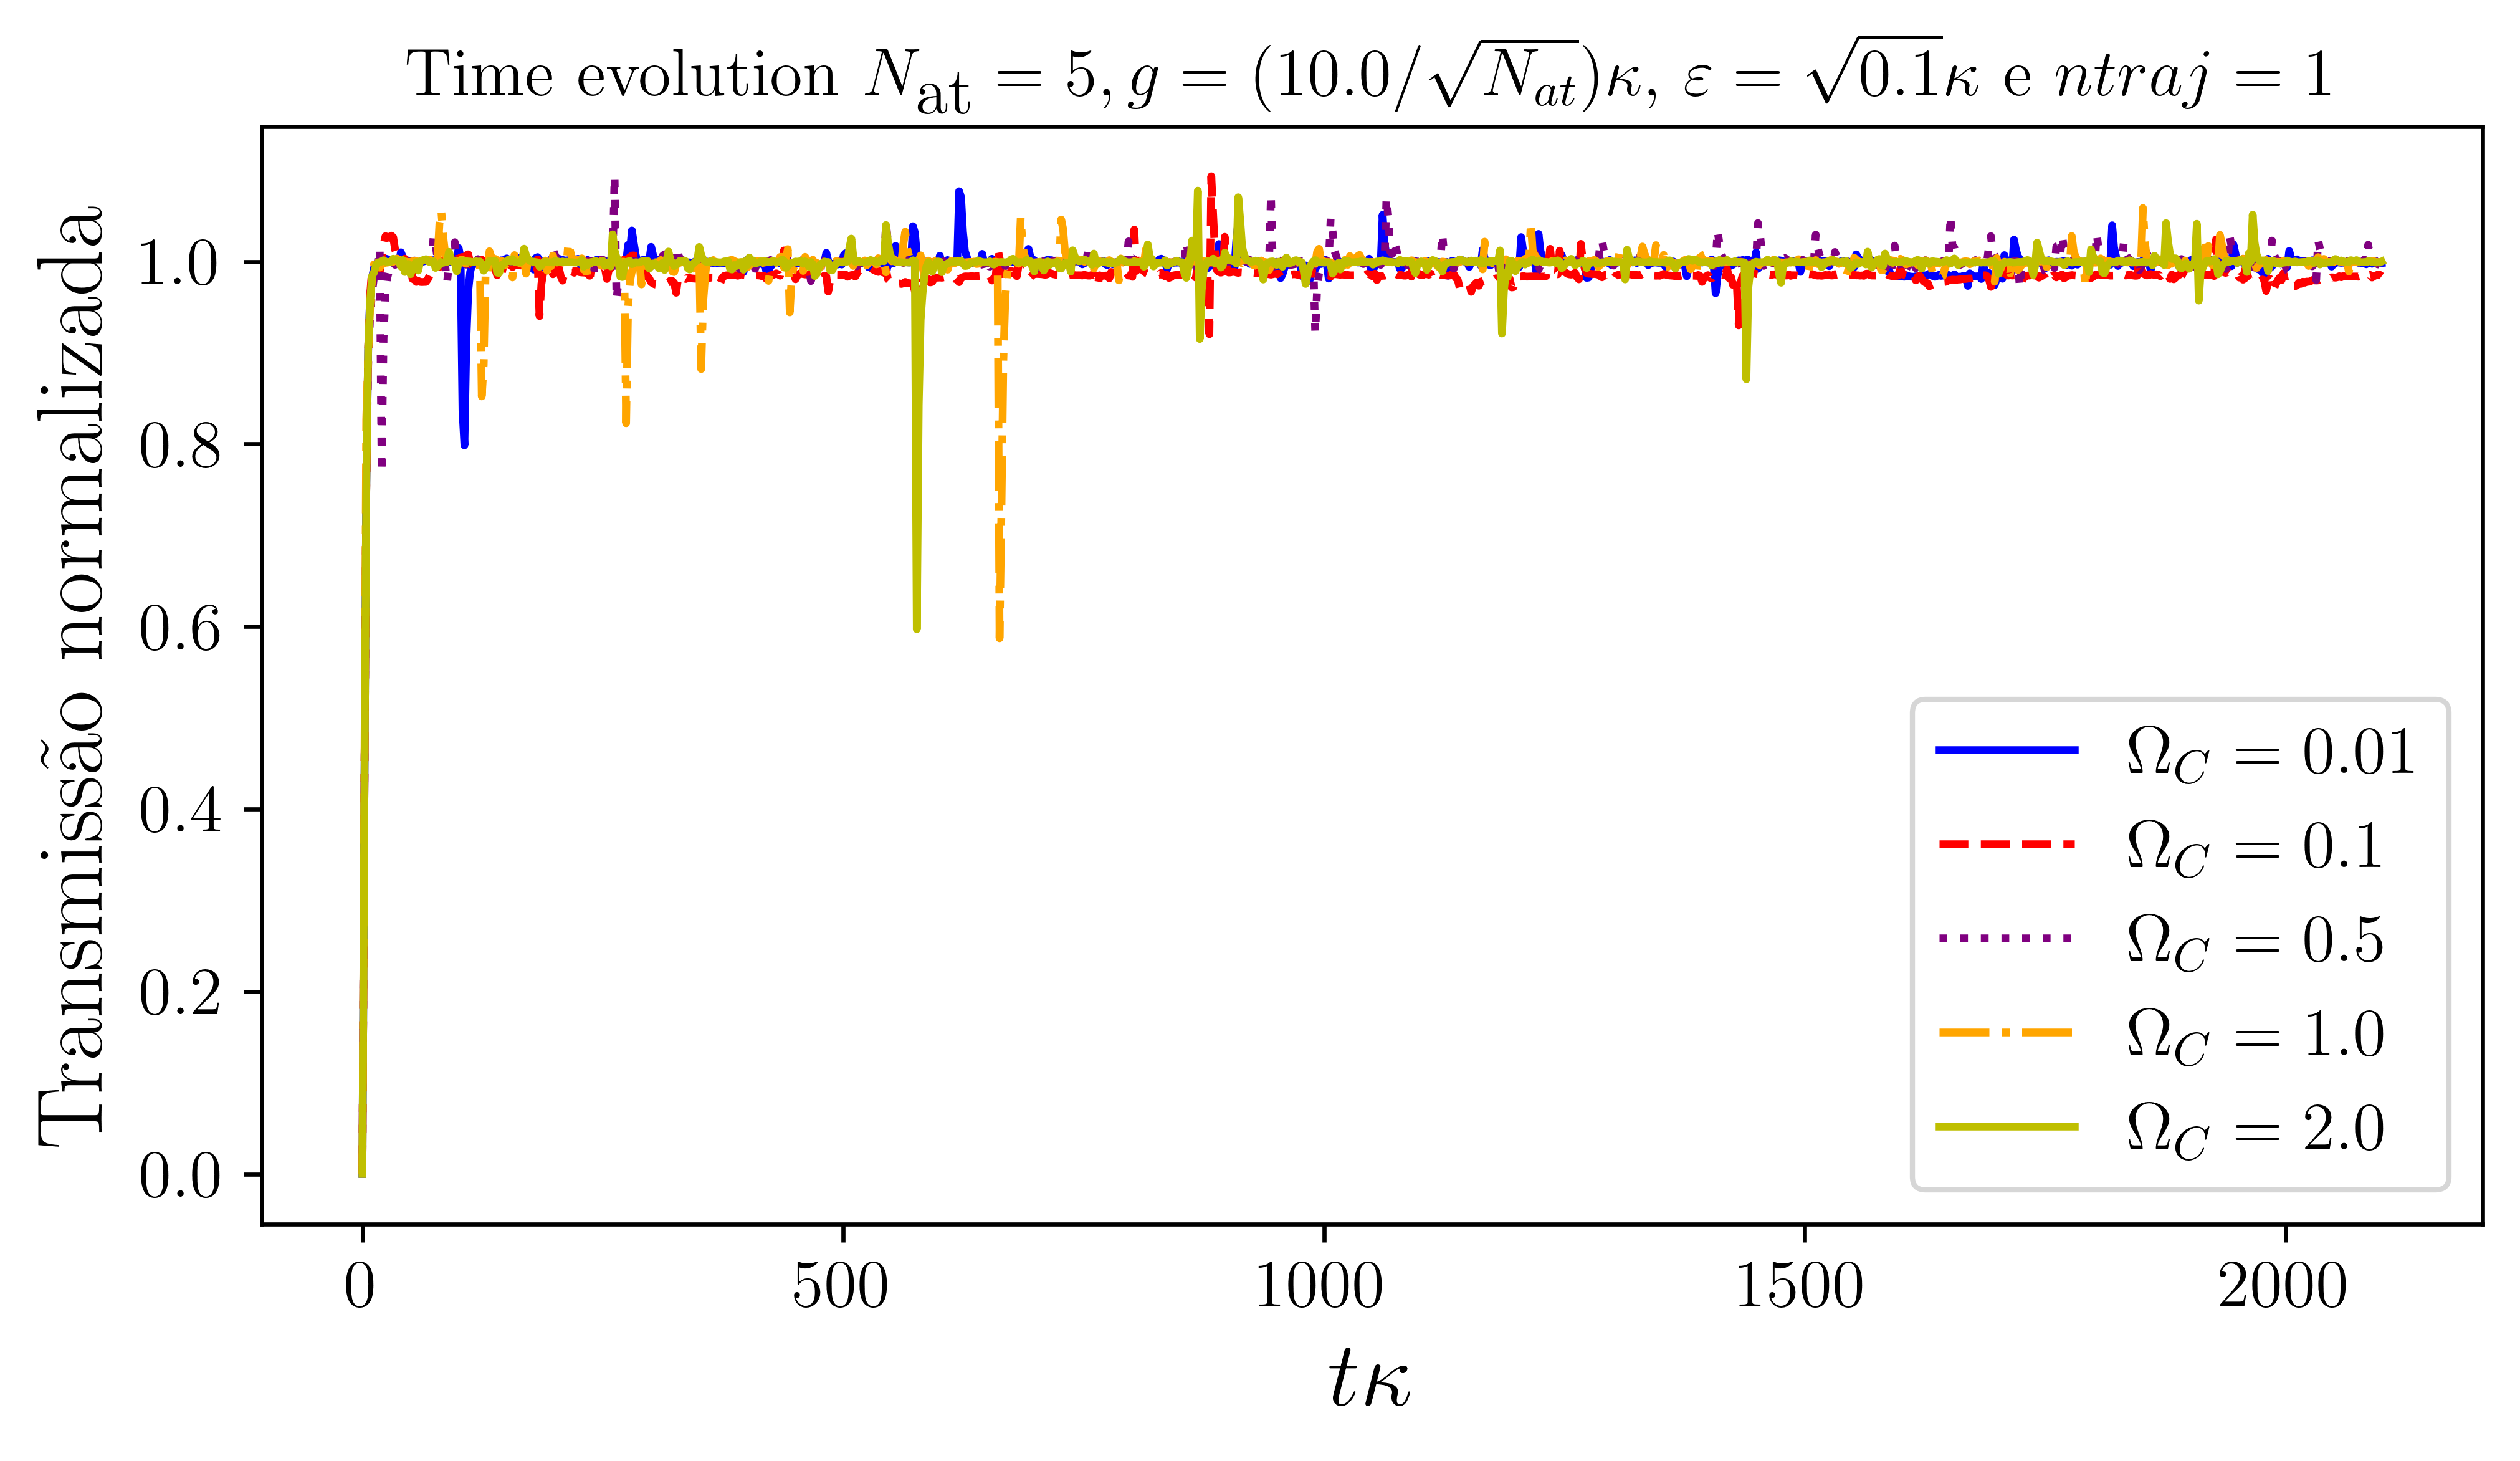

In [43]:
#test plot

fig = plt.figure(figsize=(2*3.54,1.2*3.54), dpi=600, tight_layout=True)
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(N5[:,0],N9[:,1],color='b',linestyle='-')
ax1.plot(N5[:,0],N9[:,2],color='r',linestyle='--')
ax1.plot(N5[:,0],N9[:,3],color='purple',linestyle=':')
ax1.plot(N5[:,0],N9[:,4],color='orange',linestyle='-.')
ax1.plot(N5[:,0],N9[:,5],color='y',linestyle='-')


ax1.set_xlabel(r'$t\kappa$')
ax1.set_ylabel(r'Transmissão normalizada')
ax1.legend([r'$\Omega_C=0.01$',r'$\Omega_C=0.1$',r'$\Omega_C=0.5$',r'$\Omega_C=1.0$',r'$\Omega_C=2.0$']) 
plt.title(r'Time evolution $N_{\textrm{at}}=5, g=(10.0/\sqrt{N_{at}})\kappa$, $\varepsilon=\sqrt{0.1}\kappa$ e $ntraj=1$',fontsize=13)
#ax1.set_xlim([0,5000.0])
#ax1.set_ylim([0,1.2])
#ax1.set_yticks([min(M14[:,1]),0.97,min(M16[:,1]),1.0])
plt.show() 


plt.show()
fig.savefig('timeevolution_g1_ep01_Nat2.jpeg', format='jpeg', dpi=600)